In [2]:
# imports
from pymongo import MongoClient
import pandas as pd
import json
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

 

In [3]:

data_path = '../../dataset/train.csv'
df= pd.read_csv(data_path) # read file into panda dataframe

In [33]:
df.describe() # Data Summary
df.tail()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,TUE,CALC,MTRANS,NObeyesdad,BMI,NObeyesdad_encoded,Lifestyle_Score,MTRANS_encoded,tech_score,Diet_Quality_Score
20753,20753,1,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,2,...,0.196680,1,3,3,36.587084,3,53.760333,3,13.796718,1.733750
20754,20754,1,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,1,...,1.000000,1,3,0,17.099278,0,59.472697,3,18.165114,1.409272
20755,20755,1,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,2,...,1.198439,2,3,3,31.889841,3,47.497738,3,16.631430,0.524456
20756,20756,1,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,2,...,0.973834,2,0,6,28.899693,6,40.788854,0,3.190588,-0.201633
20757,20757,1,26.680376,1.816547,118.134898,1,1,3.000000,3.000000,2,...,0.713823,1,3,3,35.800157,3,51.452562,3,13.815396,1.640921


In [5]:
# check for null values
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [6]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# check datatypes
df.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

1. "Gender', Age, 'Height, Weight' are physical attributes
2. 'family_history_with_overweight' points out to familiarity with obesity
3. FAVC = Frequent consumption of high caloric food 
4. FCVC = Frequency of consumption of vegetables 
5. NCP = Number of main meals
6. CAEC = Consumption of food between meals 
7. SMOKE = tobacco usage
8. CH20 = Consumption of water daily
9. SCC = Calories consumption monitoring 
10. FAF = Physical activity frequency 
11. TUE = Time using technology devices 
12. CALC = Consumption of alcohol
13. MTRANS = Transportation used
14. NObeyesdad = Obesity level Classification

In [8]:
df["BMI"] = df["Weight"]/df["Height"]**2 # I

In [9]:
df[["Height","Weight","BMI"]].head()

,Height,Weight,BMI
0,1.699998,81.669950,28.259565
1,1.560000,57.000000,23.422091
2,1.711460,50.165754,17.126706
3,1.710730,131.274851,44.855798
4,1.914186,93.798055,25.599151


In [10]:
df.corr(numeric_only= True)

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,1.000000,0.007634,0.012041,0.014020,0.002098,-0.000332,0.007917,0.016719,0.007667,0.011191
Age,0.007634,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154,0.320842
Height,0.012041,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433,0.098126
Weight,0.014020,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471,0.941071
FCVC,0.002098,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843,0.296933
NCP,-0.000332,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459,0.048736
CH2O,0.007917,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654,0.292142
FAF,0.016719,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213,-0.210239
TUE,0.007667,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000,-0.117098
BMI,0.011191,0.320842,0.098126,0.941071,0.296933,0.048736,0.292142,-0.210239,-0.117098,1.000000


<Axes: >

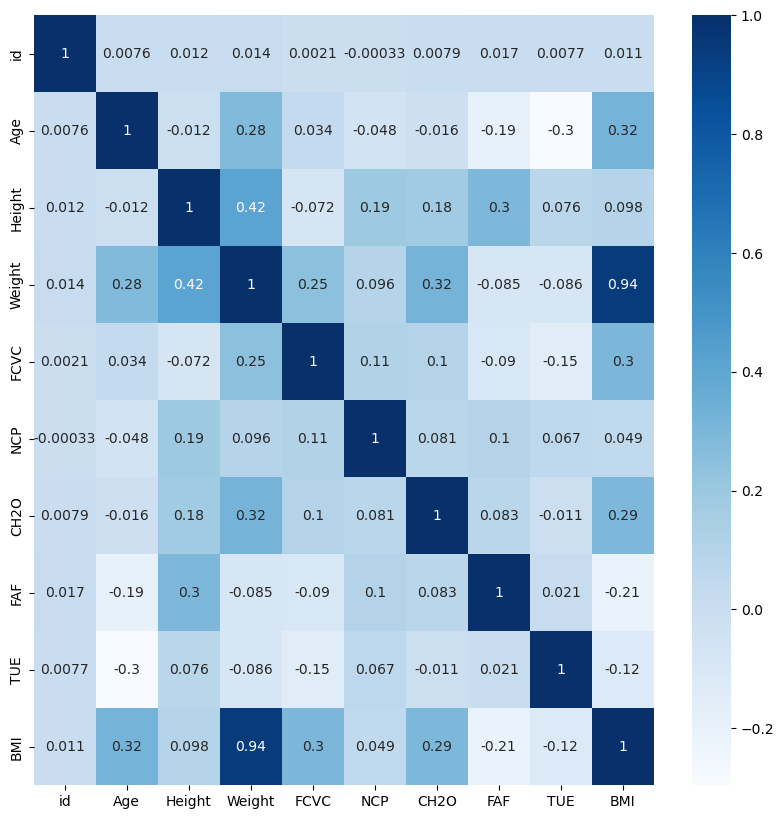

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True),annot = True,cmap= 'Blues')

In [12]:
numerical = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS', 'CALC' , 'NObeyesdad']

In [13]:

label_encoder = LabelEncoder()

# Encode the target column
df['NObeyesdad_encoded'] = label_encoder.fit_transform(df['NObeyesdad'])
correlation_ls = df[['FCVC', 'NCP', 'CH2O', 'FAF', 'NObeyesdad_encoded']].corr()['NObeyesdad_encoded']

# Display the correlation results for analysis
print(correlation_ls)

FCVC                  0.041076
NCP                  -0.091154
CH2O                  0.187100
FAF                  -0.096643
NObeyesdad_encoded    1.000000
Name: NObeyesdad_encoded, dtype: float64


In [14]:
# we are using absolute values so ignoring -ve sign
total_corr =   0.041 + 0.091 + 0.187 + 0.096
fcvc = 0.041
ncp = 0.091
ch20 = 0.187
faf = 0.096
# calculating weights
w_fcvc = total_corr/fcvc
w_ncp = total_corr/ncp
w_ch20 = total_corr/ch20
w_faf = total_corr/faf

In [15]:
# Introduced lifestyle score
# Higher values indicate healthier habits.
df["Lifestyle_Score"] = (df["FCVC"] * w_fcvc + df["NCP"] * w_ncp + df["CH2O"] * w_ch20 + df["FAF"] * w_faf)

In [16]:
# meal habits 
#df["meal_habit"] = df["FCVC"]*df["NCP"]

In [17]:

label_encoder = LabelEncoder()

# Encode the target column
df['NObeyesdad_encoded'] = label_encoder.fit_transform(df['NObeyesdad'])
df['MTRANS_encoded'] = label_encoder.fit_transform(df['MTRANS'])
correlation_ts = df[['TUE', 'MTRANS_encoded', 'FAF', 'NObeyesdad_encoded']].corr()['NObeyesdad_encoded']

# Display the correlation results for analysis
print(correlation_ts)

TUE                  -0.076040
MTRANS_encoded       -0.077430
FAF                  -0.096643
NObeyesdad_encoded    1.000000
Name: NObeyesdad_encoded, dtype: float64


In [18]:
# we are using absolute values so ignoring -ve sign
total_corr =   0.076+0.077+0.096
tue =  0.076
mtrans= 0.077
faf = 0.096
# calculating weights
w_tue = total_corr/tue
w_mtrans = total_corr/mtrans
w_faf = total_corr/faf

In [19]:
# intoduced lifestyle score
df["tech_score"] = (df["TUE"] * w_tue + df["MTRANS_encoded"] * w_mtrans + df["FAF"] * w_faf)

In [20]:

# Calculate Z-scores for each dietary feature
df['FAVC'] = df['FAVC'].map({'yes': 1, 'no': 0})

z_fcvc = zscore(df['FCVC'])
z_ch2o = zscore(df['CH2O'])
z_ncp= zscore(df['NCP'])
z_favc = zscore(df['FAVC'])

df['Diet_Quality_Score'] = z_ch2o + z_favc + z_fcvc + z_ncp

# Display the results
df[['FCVC', 'CH2O', 'NCP', 'FAVC', 'Diet_Quality_Score']].head()


,FCVC,CH2O,NCP,FAVC,Diet_Quality_Score
0,2.000000,2.763573,2.983297,1,0.990878
1,2.000000,2.000000,3.000000,1,-0.240385
2,1.880534,1.910378,1.411685,1,-2.863519
3,3.000000,1.674061,3.000000,1,1.099380
4,2.679664,1.979848,1.971472,1,-0.456994


In [21]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,...,TUE,CALC,MTRANS,NObeyesdad,BMI,NObeyesdad_encoded,Lifestyle_Score,MTRANS_encoded,tech_score,Diet_Quality_Score
0,0,Male,24.443011,1.699998,81.669950,yes,1,2.000000,2.983297,Sometimes,...,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565,6,39.982111,3,12.900533,0.990878
1,1,Female,18.000000,1.560000,57.000000,yes,1,2.000000,3.000000,Frequently,...,1.000000,no,Automobile,Normal_Weight,23.422091,1,42.686640,0,5.870066,-0.240385
2,2,Female,18.000000,1.711460,50.165754,yes,1,1.880534,1.411685,Sometimes,...,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706,0,33.456027,3,17.430793,-2.863519
3,3,Female,20.952737,1.710730,131.274851,yes,1,3.000000,3.000000,Sometimes,...,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798,4,54.107784,3,16.064747,1.099380
4,4,Male,31.641081,1.914186,93.798055,yes,1,2.679664,1.971472,Sometimes,...,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151,6,49.015371,3,17.858341,-0.456994


In [22]:

correlation_ff = df[['Diet_Quality_Score', 'tech_score', 'Lifestyle_Score', 'NObeyesdad_encoded']].corr()['NObeyesdad_encoded']

# Display the correlation results for analysis
print(correlation_ff)

Diet_Quality_Score    0.067851
tech_score           -0.128023
Lifestyle_Score      -0.021795
NObeyesdad_encoded    1.000000
Name: NObeyesdad_encoded, dtype: float64


In [23]:

correlation_ff = df[['Diet_Quality_Score', 'tech_score', 'Lifestyle_Score', 'BMI']].corr()['BMI']

# Display the correlation results for analysis
print(correlation_ff)

Diet_Quality_Score    0.393343
tech_score           -0.131912
Lifestyle_Score       0.179407
BMI                   1.000000
Name: BMI, dtype: float64


In [24]:

correlation_ff = df[['Diet_Quality_Score', 'tech_score', 'Lifestyle_Score', 'Weight']].corr()['Weight']

# Display the correlation results for analysis
print(correlation_ff)

Diet_Quality_Score    0.409467
tech_score           -0.076363
Lifestyle_Score       0.226383
Weight                1.000000
Name: Weight, dtype: float64


In [25]:
numerical = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'MTRANS', 'CALC' , 'NObeyesdad']


# Initialize LabelEncoder
label_encoders = {}

# Fit LabelEncoder to each categorical column
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Print the fitted LabelEncoders
for col, le in label_encoders.items():
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Gender: {'Female': 0, 'Male': 1}
family_history_with_overweight: {'no': 0, 'yes': 1}
FAVC: {0: 0, 1: 1}
CAEC: {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3}
SMOKE: {'no': 0, 'yes': 1}
SCC: {'no': 0, 'yes': 1}
MTRANS: {'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4}
CALC: {'Frequently': 0, 'Sometimes': 1, 'no': 2}
NObeyesdad: {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [26]:
print(df.dtypes)

id                                  int64
Gender                              int64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FAVC                                int64
FCVC                              float64
NCP                               float64
CAEC                                int64
SMOKE                               int64
CH2O                              float64
SCC                                 int64
FAF                               float64
TUE                               float64
CALC                                int64
MTRANS                              int64
NObeyesdad                          int64
BMI                               float64
NObeyesdad_encoded                  int64
Lifestyle_Score                   float64
MTRANS_encoded                      int64
tech_score                        float64
Diet_Quality_Score                

In [27]:
X = df.drop(['NObeyesdad','BMI','MTRANS_encoded', 'NObeyesdad_encoded','Gender','Weight','Age','Height','id'], axis=1)
y = df['NObeyesdad']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_),
                          n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, 
                          colsample_bytree=0.8, gamma=1, reg_lambda=1, reg_alpha=1, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report_str)



Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       524
           1       0.55      0.74      0.63       626
           2       0.55      0.62      0.58       543
           3       0.79      0.88      0.83       657
           4       0.97      0.99      0.98       804
           5       0.51      0.32      0.39       484
           6       0.51      0.40      0.45       514

    accuracy                           0.69      4152
   macro avg       0.67      0.66      0.66      4152
weighted avg       0.69      0.69      0.69      4152



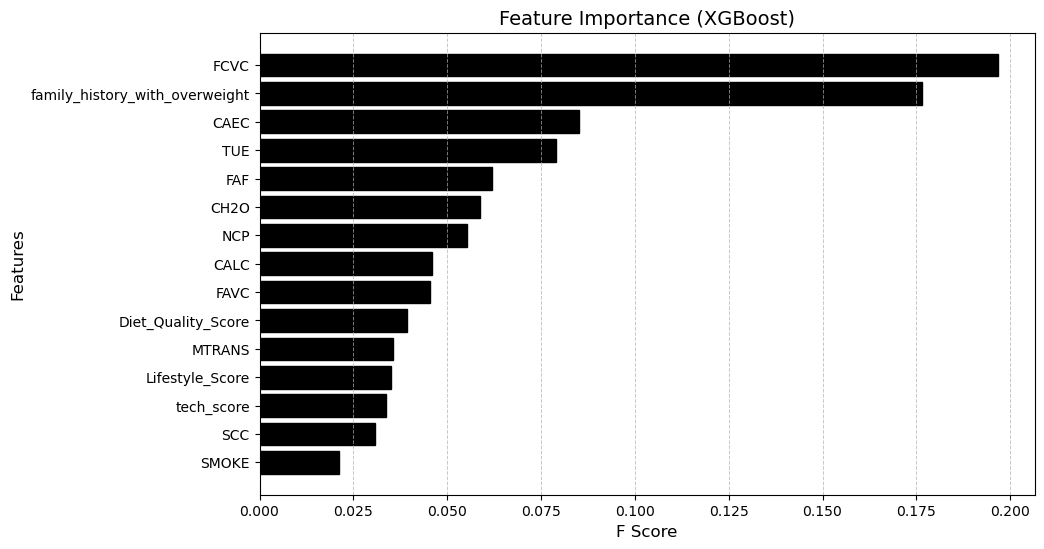

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Map feature importance to feature names
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='black', edgecolor='black')
plt.xlabel("F Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.gca().invert_yaxis()  # Invert the y-axis for descending order
plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


In [31]:
# SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train the SVM model

svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

print("SVM Test Accuracy:", accuracy_svm)
print("\nSVM Classification Report:\n", report_svm)


SVM Test Accuracy: 0.6213872832369942

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       524
           1       0.53      0.37      0.44       626
           2       0.48      0.62      0.54       543
           3       0.60      0.78      0.68       657
           4       0.90      0.99      0.94       804
           5       0.47      0.33      0.39       484
           6       0.50      0.39      0.44       514

    accuracy                           0.62      4152
   macro avg       0.59      0.59      0.58      4152
weighted avg       0.61      0.62      0.61      4152



In [32]:
# MLP
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert labels to one-hot encoding for MLP classification
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

# Define the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
mlp = model.fit(X_train, y_train_oh, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=[str(label) for label in label_encoder.classes_])

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

KeyboardInterrupt: 

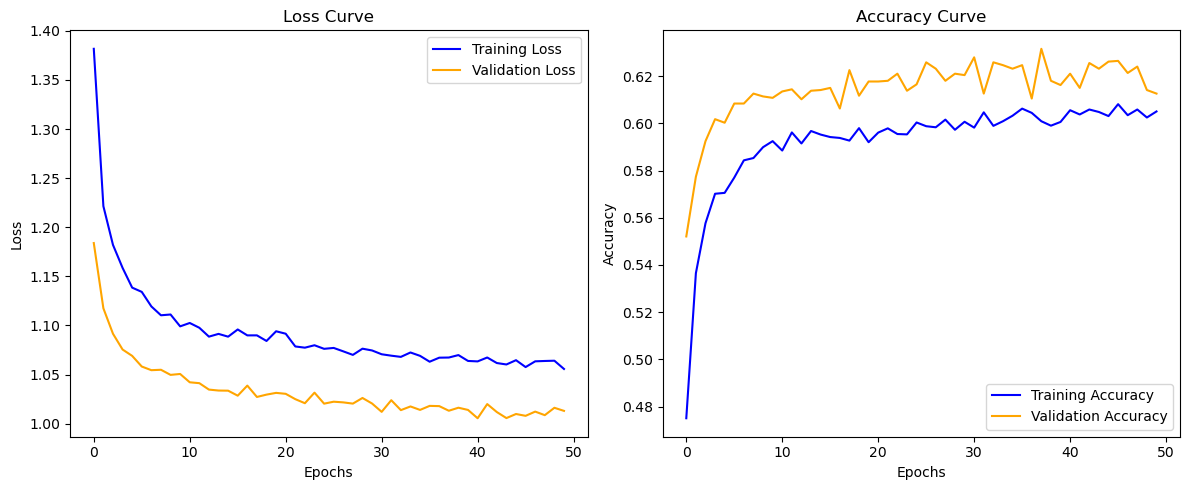

In [ ]:
import matplotlib.pyplot as plt

# Plot validation loss and accuracy
plt.figure(figsize=(12, 5))

# Validation loss
plt.subplot(1, 2, 1)
plt.plot(mlp.history['loss'], label='Training Loss', color='blue')
plt.plot(mlp.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(mlp.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(mlp.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
